In [1]:
import scipy.io.wavfile
import numpy as np
from math import floor
import scipy.signal as signal
from scipy.signal import lfilter, resample
from scipy.signal.windows import hann
from numpy.random import randn 
import matplotlib.pyplot as plt

In [2]:
# First we encode the signal by obtaining coefficients from the source-filter model.
"""
Split the original signal into overlapping blocks

x - a vector representing the time-series signal
w - array corresponding to weights of the window function
R - optional overlapping factor

Returns:

B - list of overlapping blocks
"""
def create_overlapping_blocks(x, w, R = 0.5):
    n = len(x)
    nw = len(w)
    step = floor(nw * (1 - R))
    nb = floor((n - nw) / step) + 1

    B = np.zeros((nb, nw))

    
    for i in range(nb):
        offset = i * step
        B[i, :] = w * x[offset : nw + offset]
        
    return B

def make_matrix_X(x, p):
    n = len(x)
    # [x_n, ..., x_1, 0, ..., 0]
    xz = np.concatenate([x[::-1], np.zeros(p)])
    
    X = np.zeros((n - 1, p))
    for i in range(n - 1):
        offset = n - 1 - i 
        X[i, :] = xz[offset : offset + p]
    return X

"""
An implementation of LPC.

A detailed explanation can be found at
https://ccrma.stanford.edu/~hskim08/lpc/

x - a vector representing the time-series signal
p - the polynomial order of the all-pole filter

a - the coefficients to the all-pole filter
g - the variance(power) of the source (scalar)
e - the full error signal

NOTE: This is not the most efficient implementation of LPC.
Matlab's own implementation uses FFT to via the auto-correlation method
which is noticeably faster. (O(n log(n)) vs O(n^2))
"""
def solve_lpc(x, p, ii):
    b = x[1:].T
        
    X = make_matrix_X(x, p)
    
    a = np.linalg.lstsq(X, b)[0]

    e = b.T - np.dot(X, a)
    g = np.var(e)

    return [a, g]

"""
Encodes the input signal into lpc coefficients using 50% OLA

x - single channel input signal
p - lpc order
nw - window length
 
A - the coefficients
G - the signal power
E - the full source (error) signal
"""
def lpc_encode(x, p, w):
    B = create_overlapping_blocks(x, w)
    
    [nb, nw] = B.shape

    A = np.zeros((p, nb))
    G = np.zeros((1, nb))

    for i in range(nb):
        [a, g] = solve_lpc(B[i, :], p, i)
   
        A[:, i] = a
        G[:, i] = g
    
    return [A, G]

In [3]:
# Then we decoding the signal by simulating a source-filter model

"""
Reconstruct the original signal from overlapping blocks

B - list of overlapping blocks (see create_overlapping_blocks)

x - the rendered signal
"""
def add_overlapping_blocks(B, R = 0.5):
    [count, nw] = B.shape
    step = floor(nw * R)

    n = (count-1) * step + nw

    x = np.zeros((n, ))

    for i in range(count):
        offset = i * step
        x[offset : nw + offset] += B[i, :]

    return x


def run_source_filter(a, g, block_size):
    src = np.sqrt(g)*randn(block_size, 1) # noise
    
    b = np.concatenate([np.array([-1]), a])
    
    x_hat = lfilter([1], b.T, src.T).T 
    return np.squeeze(x_hat)
    

"""
Decodes the LPC coefficients into

* A - the LPC filter coefficients
* G - the signal power(G) or the signal power with fundamental frequency(GF) 
       or the full source signal(E) of each windowed segment.
* w - the window function
* lowcut - the cutoff frequency in normalized frequencies for a lowcut
          filter.
"""
def lpc_decode(A, G, w, lowcut = 0):


    [ne, n] = G.shape
    nw = len(w)
    [p, _] = A.shape

    B_hat = np.zeros((n, nw))

    for i in range(n):
        B_hat[i,:] = run_source_filter(A[:, i], G[:, i], nw)

    # recover signal from blocks
    x_hat = add_overlapping_blocks(B_hat)
        
    return x_hat

# MainApp

In [4]:
[sample_rate, amplitudes] = scipy.io.wavfile.read('./speech.wav')
amplitudes = np.array(amplitudes)

# normalize
amplitudes = 0.9*amplitudes/max(abs(amplitudes)); 

# resampling to 8kHz
target_sample_rate = 8000
target_size = int(len(amplitudes)*target_sample_rate/sample_rate)
amplitudes = resample(amplitudes, target_size) 
sample_rate = target_sample_rate

# 30ms Hann window
sym = False # periodic
w = hann(floor(0.03*sample_rate), sym) 

# Encode
p = 6 # number of poles
[A, G] = lpc_encode(amplitudes, p, w)

# Print stats
original_size = len(amplitudes)
model_size = A.size + G.size
print('Taille du signal original:', original_size)
print('Taille du signal encodé:', model_size)
print('Taux de réduction: ', original_size/model_size)

xhat = lpc_decode(A, G, w)

scipy.io.wavfile.write("example.wav", sample_rate, xhat)
print('done')

C:\Users\Massamba Sene\AppData\Local\Temp\ipykernel_19960\2190768896.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(X, b)[0]


Taille du signal original: 96249
Taille du signal encodé: 5607
Taux de réduction:  17.165864098448367
done


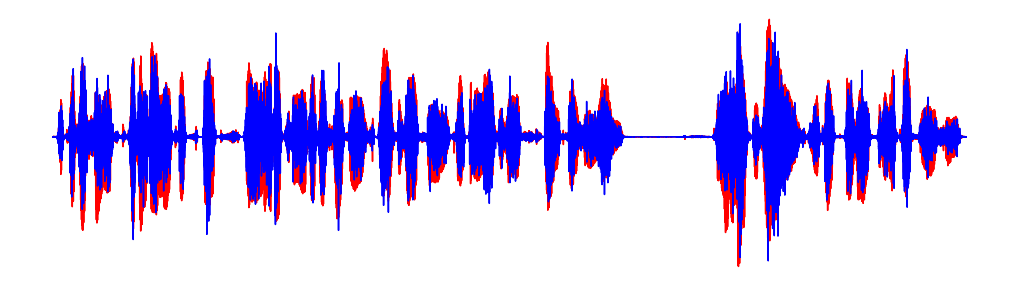

In [5]:
# We visualize the original signal and the decoded signal

fig = plt.figure(figsize=(18, 5))
n = len(amplitudes)
ts = np.array(range(0, n))
plt.plot(ts, amplitudes, 'r')
xhat_padded = np.concatenate([xhat, np.zeros(n - len(xhat))])
plt.plot(ts, xhat_padded, 'b')
plt.axis("off")
plt.show()


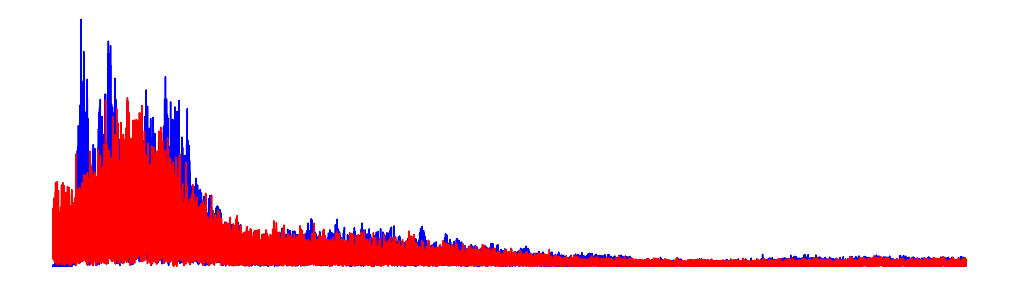

In [6]:
# Visualize the original signal and the decoded signal in the frequency domain

from scipy.fft import fft, fftfreq

xhat_extended = np.concatenate([xhat, np.zeros(n - len(xhat))])

N = len(amplitudes)
F = 1.0/sample_rate
yf1 = fft(amplitudes)
yf2 = fft(xhat_extended)

xf = fftfreq(N, F)[:N//2]

fig = plt.figure(figsize=(18, 5))
plt.plot(xf, 2.0/N * np.abs(yf1[0:N//2]), 'b')
plt.plot(xf, 2.0/N * np.abs(yf2[0:N//2]), 'r')
plt.axis("off")
plt.show()

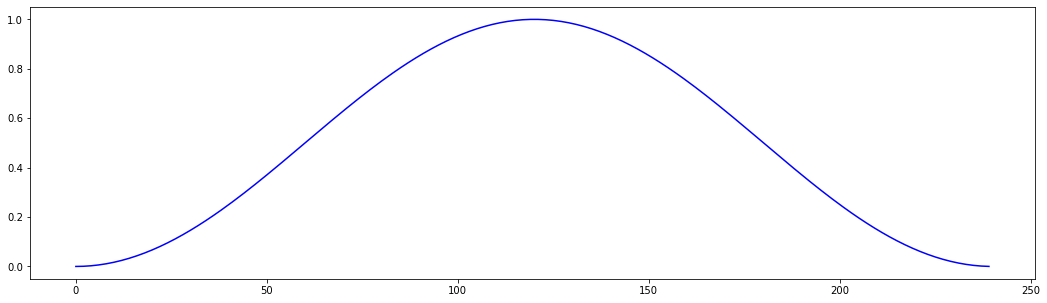

In [7]:
# Finally we can visualize the Hann window weights

sym = False # periodic
window_size = floor(0.03*sample_rate)
window = hann(window_size, sym) 
t = np.array(range(window_size))
fig = plt.figure(figsize=(18, 5))
plt.plot(t, window, 'b')
plt.show()